In [ ]:
# === 1. LIBRARIES ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/childhood-malnutrition-trends-dataset/malnutrition_data (1).csv")

# Label Encoding target
le = LabelEncoder()
df['nutrition_status_encoded'] = le.fit_transform(df['nutrition_status'])  # 0=moderate, 1=normal, 2=severe

# Confirm encoding
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Check for missing values
print(df.isnull().sum())

# Dataset preview
df.head()


{'moderate': 0, 'normal': 1, 'severe': 2}
age_months                  0
weight_kg                   0
height_cm                   0
muac_cm                     0
bmi                         0
nutrition_status            0
nutrition_status_encoded    0
dtype: int64


,age_months,weight_kg,height_cm,muac_cm,bmi,nutrition_status,nutrition_status_encoded
0,12.345052,3.000000,54.134002,13.160919,10.0,normal,1
1,30.807200,5.459076,76.199180,13.944380,10.0,normal,1
2,15.723226,3.000000,60.280820,13.243565,10.0,normal,1
3,57.796256,10.103074,104.990471,14.105683,10.0,normal,1
4,40.321320,7.110583,85.277902,14.641630,10.0,normal,1


        age_months    weight_kg    height_cm      muac_cm          bmi  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     30.329540     5.285254    75.150343    13.441465    10.004274   
std      17.152432     2.340930    17.332621     0.885567     0.047272   
min       1.000686     3.000000    45.000000    10.261992    10.000000   
25%      15.296946     3.000000    60.180769    12.849444    10.000000   
50%      30.607902     4.648996    75.010021    13.635633    10.000000   
75%      45.143969     7.043410    89.366628    14.082577    10.000000   
max      59.989601    10.726919   105.000000    15.715103    11.285436   

       nutrition_status_encoded  
count               5000.000000  
mean                   0.850000  
std                    0.517256  
min                    0.000000  
25%                    1.000000  
50%                    1.000000  
75%                    1.000000  
max                    2.000000  


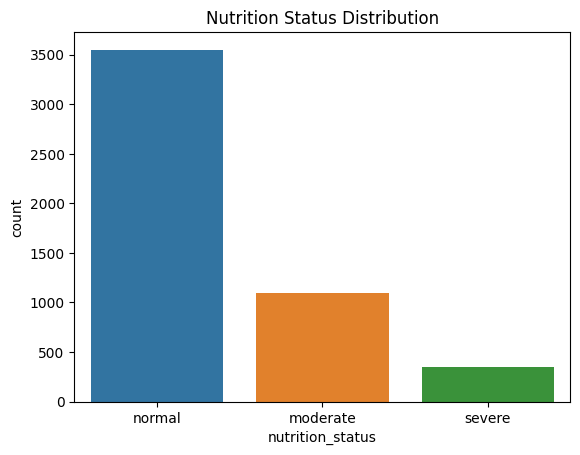

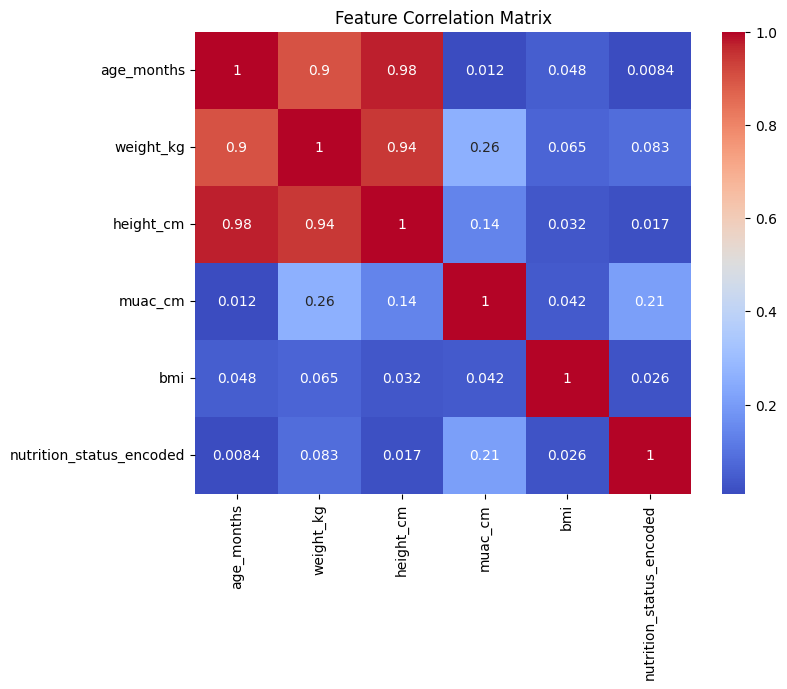

In [4]:
def run_eda(df):
    print(df.describe())

    # Target distribution
    sns.countplot(x='nutrition_status', data=df)
    plt.title("Nutrition Status Distribution")
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.drop('nutrition_status', axis=1).corr(), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()

run_eda(df)


In [10]:
# Features and target
X = df[['age_months', 'weight_kg', 'height_cm', 'muac_cm', 'bmi']]
y = df['nutrition_status_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
# Base Models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression()

# Ensemble Voting Classifier
ensemble = VotingClassifier(estimators=[('rf', rf), ('lr', lr)], voting='soft')
ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr', LogisticRegression())],
                 voting='soft')

In [13]:
def custom_risk_score(age, weight, muac):
    if age < 24 and weight < 5 and muac < 11.5:
        return "High Risk"
    elif muac < 12.5:
        return "Moderate Risk"
    else:
        return "Low Risk"

# Example
print(custom_risk_score(18, 4.5, 11.0))


High Risk


Classification Report:
              precision    recall  f1-score   support

    moderate       0.86      0.87      0.86       198
      normal       0.98      0.99      0.98       734
      severe       0.79      0.74      0.76        68

    accuracy                           0.95      1000
   macro avg       0.88      0.86      0.87      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix:


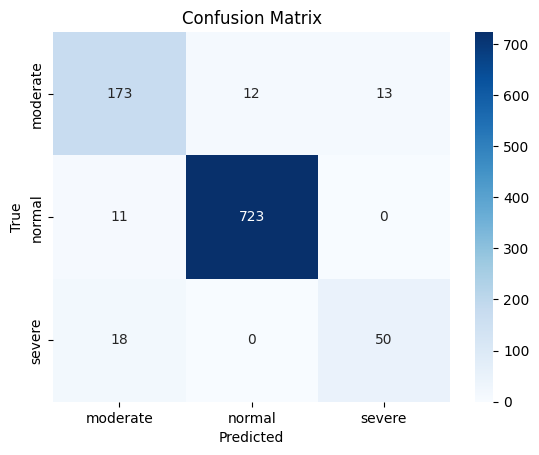

Accuracy: 0.946


In [14]:
def evaluate_model(model, X_test, y_test, le):
    y_pred = model.predict(X_test)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("Accuracy:", accuracy_score(y_test, y_pred))

evaluate_model(ensemble, X_test, y_test, le)


In [15]:
df.to_csv("cleaned_malnutrition_data.csv", index=False)